# **WIP Collaborative Filtering**

#Step 1: Selection / Read case / Install Done
#Step 2: Data review (type) / EDA Done
#Step 3: JOIN link md and ratings Done
#Step 4: EDA Done
#Step 5: run Colab filtering Done
#Step 6: Clean / Iterate Done
#Step 7: Predict Done

#Step 8: Check if item is indeed in top list of user 36. And not in list
#Step 9: Run augmented code to see recommended movies
#Step 10: Check if recommended movies make sense
#Step TBD: Check what went wrong with the list of movies joined

#Step 11: Github / Derive Code for dashboard
#Step 12: Run dashboard
#Step 13: Iterate/clean
#Step 14: Github

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
from surprise import Reader, Dataset, SVD, evaluate

import warnings; warnings.simplefilter('ignore')

In [2]:
#DOWNLOAD data to dataframe
reader = Reader()
#ratings = pd.read_csv('../input/tmdb-ratings_small/tmdb_5000_movies.csv')
rd = pd.read_csv('/kaggle/input/the-movies-dataset/ratings_small.csv')
md= pd.read_csv('/kaggle/input/the-movies-dataset/movies_metadata.csv')
ld= pd.read_csv('/kaggle/input/the-movies-dataset/links.csv')
#ratings.head()
rd.head(3)

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182


In [3]:
#metadata head
md.head(3)


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.9469,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.0155,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0


In [4]:
#EXPLORE link data head
ld.head(3)


,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0


In [5]:
#CHECK NULL VALUES
#null_values = rd.isnull()
#print(null_values)
rd.info()
ld.info()
md.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100004 entries, 0 to 100003
Data columns (total 4 columns):
userId       100004 non-null int64
movieId      100004 non-null int64
rating       100004 non-null float64
timestamp    100004 non-null int64
dtypes: float64(1), int64(3)
memory usage: 3.1 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45843 entries, 0 to 45842
Data columns (total 3 columns):
movieId    45843 non-null int64
imdbId     45843 non-null int64
tmdbId     45624 non-null float64
dtypes: float64(1), int64(2)
memory usage: 1.0 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
adult                    45466 non-null object
belongs_to_collection    4494 non-null object
budget                   45466 non-null object
genres                   45466 non-null object
homepage                 7782 non-null object
id                       45466 non-null object
imdb_id                  45449 non-null object
origin

In [6]:
# MERGE rd with ld so as to append a linking variable tmdbId that can connect with md (md has movie titles)
rd_ld = pd.merge(rd, ld, on='movieId')
rd_ld.head(5)
rd_ld.info()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 99958 entries, 0 to 99957
Data columns (total 6 columns):
userId       99958 non-null int64
movieId      99958 non-null int64
rating       99958 non-null float64
timestamp    99958 non-null int64
imdbId       99958 non-null int64
tmdbId       99898 non-null float64
dtypes: float64(2), int64(4)
memory usage: 5.3 MB


In [7]:
#RENAME new rd_ld DB's ID so as to mirror md's ID before merging
rd_ld = rd_ld.rename(columns={'tmdbId': 'id'})
rd_ld.head(5)  # Output:   new_column

,userId,movieId,rating,timestamp,imdbId,id
0,1,31,2.5,1260759144,112792,9909.0
1,7,31,3.0,851868750,112792,9909.0
2,31,31,4.0,1273541953,112792,9909.0
3,32,31,4.0,834828440,112792,9909.0
4,36,31,3.0,847057202,112792,9909.0


In [8]:
# CONVERT md ID column to numeric before merging
md['id'] = pd.to_numeric(md['id'], errors='coerce')
print(md['id'].dtype)  # Output: float64
md.info()

float64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
adult                    45466 non-null object
belongs_to_collection    4494 non-null object
budget                   45466 non-null object
genres                   45466 non-null object
homepage                 7782 non-null object
id                       45463 non-null float64
imdb_id                  45449 non-null object
original_language        45455 non-null object
original_title           45466 non-null object
overview                 44512 non-null object
popularity               45461 non-null object
poster_path              45080 non-null object
production_companies     45463 non-null object
production_countries     45463 non-null object
release_date             45379 non-null object
revenue                  45460 non-null float64
runtime                  45203 non-null float64
spoken_languages         45460 non-null object
status                   45379 non-n

In [9]:
# MERGED DATASET - eventually didn't help me much either LOL
# MERGE rd ld md so that userID movie name and ratings can all be connected in same file
rd_ld_md = pd.merge(rd_ld, md, on='id')
movie_ratings_joined = rd_ld_md[['userId', 'movieId','id', 'title', 'budget','genres', 'popularity','revenue', 'production_countries', 'vote_average', 'rating']]
#print(movie_ratings_joined)
movie_ratings_joined.tail(5)
#movie_ratings_joined.info()

,userId,movieId,id,title,budget,genres,popularity,revenue,production_countries,vote_average,rating
100025,664,64997,34812.0,H.G. Wells' War of the Worlds,1000000,"[{'id': 878, 'name': 'Science Fiction'}]",1.31408,0.0,"[{'iso_3166_1': 'US', 'name': 'United States o...",4.4,2.5
100026,664,72380,22825.0,The Box,30000000,"[{'id': 53, 'name': 'Thriller'}, {'id': 878, '...",10.4249,33333531.0,"[{'iso_3166_1': 'US', 'name': 'United States o...",5.4,3.5
100027,665,129,110972.0,Pie in the Sky,0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...",0.699066,0.0,[],7.0,3.0
100028,665,4736,26602.0,Summer Catch,34000000,"[{'id': 18, 'name': 'Drama'}, {'id': 35, 'name...",5.49987,19693891.0,"[{'iso_3166_1': 'US', 'name': 'United States o...",4.8,1.0
100029,668,6425,36807.0,The Sixth Man,0,"[{'id': 14, 'name': 'Fantasy'}, {'id': 18, 'na...",3.74765,0.0,"[{'iso_3166_1': 'US', 'name': 'United States o...",5.0,1.0


In [10]:
movie_ratings_joined.shape
#movie_ratings_joined.info()


(100030, 11)

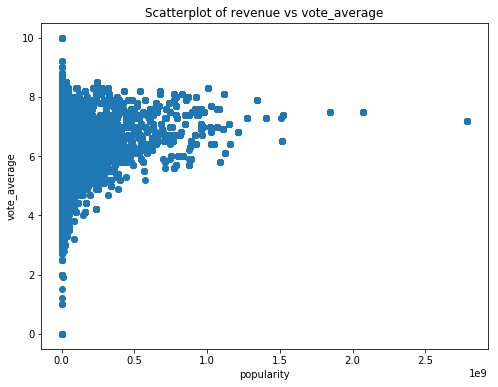

In [11]:
# EDA (didn't help me much)
plt.figure(figsize=(8, 6))
plt.scatter(movie_ratings_joined['revenue'], movie_ratings_joined['vote_average'])

# Add title and labels
plt.title('Scatterplot of revenue vs vote_average')
plt.xlabel('popularity')
plt.ylabel('vote_average')

# Display the plot
plt.show()


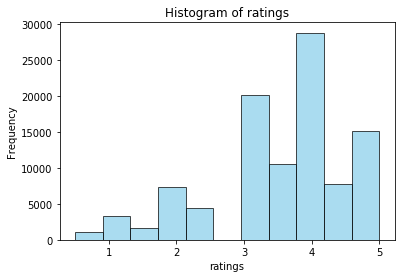

In [12]:
# HISTOGRAM (didn't help me much)
plt.hist(movie_ratings_joined['rating'], bins=11, alpha=0.7, color='skyblue', edgecolor='black')

# Add title and labels
plt.title('Histogram of ratings')
plt.xlabel('ratings')
plt.ylabel('Frequency')

# Display the plot
plt.show()

In [13]:
#CONVERT some fields to numeric from the merged dataset
movie_ratings_joined['popularity'] = pd.to_numeric(movie_ratings_joined['popularity'], errors='coerce')
print(movie_ratings_joined['popularity'].dtype)  # Output: float64
movie_ratings_joined.info()

movie_ratings_joined['vote_average'] = pd.to_numeric(movie_ratings_joined['vote_average'], errors='coerce')
print(movie_ratings_joined['vote_average'].dtype)  # Output: float64
movie_ratings_joined.info()

float64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 100030 entries, 0 to 100029
Data columns (total 11 columns):
userId                  100030 non-null int64
movieId                 100030 non-null int64
id                      99850 non-null float64
title                   99850 non-null object
budget                  100030 non-null object
genres                  100030 non-null object
popularity              99850 non-null float64
revenue                 99850 non-null float64
production_countries    100030 non-null object
vote_average            99850 non-null float64
rating                  100030 non-null float64
dtypes: float64(5), int64(2), object(4)
memory usage: 9.2+ MB
float64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 100030 entries, 0 to 100029
Data columns (total 11 columns):
userId                  100030 non-null int64
movieId                 100030 non-null int64
id                      99850 non-null float64
title                   99850 non-null object


In [14]:
# DATA REVIEW CHECKS

#Run barchartwith of production origin 

#index = md[md['id'] == '1029'].index[0]
#print(f"Value 'id' found at index {index}")
#index = md.index('139405')
#Print(f"Value '139405' found at index {index}")
#row = rd.loc[rd['movieId'] == 31]
#print(row)
#id_map = pd.read_csv('../input/links_small.csv')[['movieId', 'tmdbId']]
#id_map['tmdbId'] = id_map['tmdbId'].apply(convert_int)
#id_map.columns = ['movieId', 'id']
#id_map = id_map.merge(smd[['title', 'id']], on='id').set_index('title')

#check of TMBID can be found in md
row = md.loc[md['id'] == 9909]
row.head()

#check how many null is there
missing_values = movie_ratings_joined.isnull().sum()
#missing_values = movie_ratings_joined.isnull()
print(missing_values)
movie_ratings_joined.info()

userId                    0
movieId                   0
id                      180
title                   180
budget                    0
genres                    0
popularity              180
revenue                 180
production_countries      0
vote_average            180
rating                    0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 100030 entries, 0 to 100029
Data columns (total 11 columns):
userId                  100030 non-null int64
movieId                 100030 non-null int64
id                      99850 non-null float64
title                   99850 non-null object
budget                  100030 non-null object
genres                  100030 non-null object
popularity              99850 non-null float64
revenue                 99850 non-null float64
production_countries    100030 non-null object
vote_average            99850 non-null float64
rating                  100030 non-null float64
dtypes: float64(5), int64(2), object(4)
memory usage:

In [15]:
# EDA (didn't help me much)

# Create figure and axis
##fig, ax = plt.subplots(figsize=(10, 6))

# Plot bar chart
#ax.bar(movie_ratings_joined['production_countries'], movie_ratings_joined['vote_average'].mean())

#average_values = movie_ratings_joined.groupby('production_countries')['vote_average'].mean()
##ax.bar(movie_ratings_joined['production_countries'], movie_ratings_joined.groupby('production_countries')['vote_average'].mean())
#SHOULD TRY SQL HERE

# Set title and labels
##ax.set_title('Vote avg by country')
##ax.set_xlabel('Country')
##ax.set_ylabel('Vote AVG')

# Rotate x-axis labels for better readability
##plt.xticks(rotation=45)

# Show plot
##plt.show()

In [16]:
# RECOMMENDER BUILDING leading up to predicted ratings
from surprise import KNNWithMeans
from surprise import Dataset
from surprise.model_selection import train_test_split
from surprise import accuracy
from surprise import Reader

#df = pd.DataFrame(ratings_dict)
#df = pd.DataFrame(movie_ratings_joined)
#Define the reader
#reader = Reader(rating_scale=(1, 5))
reader = Reader()

# Build the dataset
#data = Dataset.load_from_df(movie_ratings_joined[["userId", "title", "rating"]], reader)
#data = Dataset.load_from_df(movie_ratings_joined[['userId', 'title', 'rating']], reader)
#data = Dataset.load_from_df(df[['userId', 'title', 'rating']], reader)
data = Dataset.load_from_df(rd[['userId', 'movieId', 'rating']], reader)


# Split the dataset into training and testing sets
Trainset, Testset = train_test_split(data, test_size=.25)

# Create a KNNWithMeans recommender
algo = KNNWithMeans(k=20, sim_options={'name': 'pearson_baseline', 'user_based': False})

# Train the recommender
algo.fit(Trainset)

# Make predictions on the test set
predictions = algo.test(Testset)
#predictions = algo.test(Trainset)
# Evaluate the recommender
accuracy.rmse(predictions, verbose=True)  # RMSE (Root Mean Square Error)
accuracy.mae(predictions, verbose=True)   # MAE (Mean Absolute Error)

# Make a prediction for a specific user-item pair
##prediction = algo.predict('12', '2', r_ui=4, verbose=False)
##print(prediction.est)  # Output: 4.25


Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9215
MAE:  0.7006


0.7005702327846381

In [17]:
# PREDICTION
prediction = algo.predict(36, 32, r_ui=0, verbose=False)
print(prediction.est)  # Output: 3.54066

4.597805436884711


In [18]:
# CHECK ON TOP RECOMMENDATIONS OF USER 547
#rd.loc[rd['userId'] == 547]
rd547=rd.loc[rd['userId'] == 547].sort_values(by='rating', ascending=False)

#Use the value_counts() function to count the frequency of each userId
##user_id_counts = rd['userId'].value_counts()

#Print the top 5 userIds with the highest frequency
##print(user_id_counts.nlargest(5))


In [19]:
# RECOMMENDER BUILDING + TOP 10 RECOMMENDATIONS
from surprise import KNNWithMeans
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import train_test_split

# Load the dataset
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(rd[['userId', 'movieId', 'rating']], reader)

# Split the dataset into training and testing sets
trainset, testset = train_test_split(data, test_size=.25)

# Create a KNNWithMeans algorithm object
algo = KNNWithMeans(k=20, sim_options={'name': 'pearson_baseline', 'user_based': False})

# Train the algorithm on the training set
algo.fit(trainset)

# Make predictions on the test set
predictions = algo.test(testset)

# Function to get Top-N recommendations for a user
def get_top_n_recommendations(user_id, n=10):
    # Get the user's ratings
    user_ratings = [r for r in trainset.all_ratings() if r[0] == user_id]

    # Get the user's rated items
    rated_items = [r[1] for r in user_ratings]

    # Get the predicted ratings for the user
    predicted_ratings = []
    for item in trainset.all_items():
        if item not in rated_items:
            predicted_rating = algo.predict(user_id, item, r_ui=0, verbose=False).est
            predicted_ratings.append((item, predicted_rating))

    # Sort the predicted ratings in descending order
    predicted_ratings.sort(key=lambda x: x[1], reverse=True)

    # Return the Top-N recommended items
    return predicted_ratings[:n]

# Example usage
user_id = 32  # Replace with the desired user ID
n = 10  # Replace with the desired number of recommendations

top_n_recommendations = get_top_n_recommendations(user_id, n)
print("Top-{} recommendations for user {}".format(n, user_id))
for item, rating in top_n_recommendations:
    print("Item: {}, Predicted Rating: {}".format(item, rating))

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Top-10 recommendations for user 32
Item: 53, Predicted Rating: 5
Item: 80, Predicted Rating: 5
Item: 97, Predicted Rating: 5
Item: 149, Predicted Rating: 5
Item: 178, Predicted Rating: 5
Item: 264, Predicted Rating: 5
Item: 279, Predicted Rating: 5
Item: 309, Predicted Rating: 5
Item: 318, Predicted Rating: 5
Item: 341, Predicted Rating: 5


In [20]:
# SEE MOVIE TITLES of top recommendations
top_recommendations = pd.DataFrame(top_n_recommendations, columns=['movieId', 'Rating'])
top_recommendations.head(20)

#mergedRD = pd.merge(movie_ratings_joined, top_recommendations, on='movieId')
#mergedRD.head(20)

mergedRD = pd.merge(top_recommendations[['movieId']], movie_ratings_joined[['movieId','title']], on='movieId', how='left')
df_unique = mergedRD.drop_duplicates()
df_unique

,movieId,title
0,53,Lamerica
1,80,The White Balloon
5,97,La Haine
13,149,Amateur
19,178,Love & Human Remains
24,264,L'Enfer
26,279,My Family
30,309,"Red Firecracker, Green Firecracker"
33,318,The Shawshank Redemption
344,341,Double Happiness


In [21]:
#SURPLUS CODE
#rdconcise = rd[['userId', 'movieId', 'rating']]
#rdconcise.loc[rdconcise['movieId'] == 30]
#print(row)
#rd.loc[rd['movieId'] == 559]

#To augment the Python code to include movie titles in the Top-N recommended items, you'll need to make the following modifications:

#Step 1: Merge Movie Titles with the Dataset
#Assuming you have a DataFrame movies_df containing the movie IDs and titles, merge this DataFrame with your original ratings DataFrame your_dataframe before loading it into the Surprise Dataset.
#merged_df = pd.merge(your_dataframe, movies_df, on='movieId')
##movie_ratings_joined


#Step 2: Modify the get_top_n_recommendations Function
#Update the get_top_n_recommendations function to include the movie titles in the predicted ratings list.


#def get_top_n_recommendations(user_id, n=10):
    # Get the user's ratings
#    user_ratings = [r for r in trainset.all_ratings() if r[0] == user_id]

    # Get the user's rated items
#    rated_items = [r[1] for r in user_ratings]

    # Get the predicted ratings for the user
#    predicted_ratings = []
#    for item in trainset.all_items():
#        if item not in rated_items:
#            predicted_rating = algo.predict(user_id, item, r_ui=0, verbose=False).est
            # Get the movie title from the merged DataFrame
#            movie_title = movie_ratings_joined.loc[movie_ratings_joined['movieId'] == item, 'title'].iloc[0]
#            predicted_ratings.append((item, movie_title, predicted_rating))

    # Sort the predicted ratings in descending order
#    predicted_ratings.sort(key=lambda x: x[2], reverse=True)

    # Return the Top-N recommended items
#    return predicted_ratings[:n]



#Step 3: Update the Example Usage
#Modify the example usage to print the movie titles along with the predicted ratings.
#user_id = 11  # Replace with the desired user ID
#n = 10  # Replace with the desired number of recommendations

#top_n_recommendations = get_top_n_recommendations(user_id, n)
#print("Top-{} recommendations for user {}".format(n, user_id))
#for item, title, rating in top_n_recommendations:
#    print("Item: {}, Title: {}, Predicted Rating: {}".format(item, title, rating))